In [24]:
%matplotlib inline
import pandas as pd
import numpy as np
from skimage.io import imsave
from machinedesign.autoencoder.interface import load
from machinedesign.viz import grid_of_images_default
from lightjob.cli import load_db
import keras.backend as K
import matplotlib.pyplot as plt
from IPython.display import Image
pd.options.display.max_columns = 100

def show(df):
    for j in df.index:
        print(j)
        X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
        X = grid_of_images_default(X)
        imsave('out.png', X)
        im = Image('out.png')
        display(im)
db = load_db()

Using Theano backend.


In [25]:
jobs = db.jobs_with()
rows = []
for j in jobs:
    col = {}
    if j['stats'] is None:
        continue
        
    for k, v in j['stats'].items():
        col[k] = v

    try:
        col['stride'] = j['content']['train']['model']['params']['code_activations'][1]['params']['stride']
    except Exception:
        pass
    try:
        col['nb_layers'] = len(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        col['nb_layers'] = len(j['content']['train']['model'][1]['params']['encode_nb_filters'])    

    try:
         col['zero_ratio'] = j['content']['train']['model']['params']['code_activations'][1]['params']['zero_ratio']
    except Exception:
        pass
    try:
        col['bottleneck'] = min(j['content']['train']['model']['params']['encode_nb_filters'])
    except Exception:
        pass
    try:
        col['noise'] = j['content']['train']['model'][0]['params']['params']['proba']
    except Exception:
        pass
    col['sampler'] = j['sampler']
    col['job_id'] = j['summary']
    col['noise_count'] = 1.0 - (col['digits_count'] + col['letters_count'])
    col['digits_object'] = 1 - col['digits_entropy']
    col['letters_object'] = 1 - col['letters_entropy']
    col['digits_and_letters_object'] = 1 - col['digits_and_letters_entropy']
    col['emnist_object'] = 1 - col['emnist_letters_entropy']
    rows.append(col)
    
df_full = pd.DataFrame(rows)
df_full = df_full.set_index('job_id')
df_full.to_csv('hypers.csv')

## Fix stride. vary nb of layers

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['stride']==2]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## Fix nb layers. Vary stride

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep']
df = df[df['nb_layers'] == 3]
df = df.sort_values(by='stride')
df

In [ ]:
show(df)

# wta lifetime sparsity

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_lifetime']
df = df[df['zero_ratio']==0.7]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

## wta kchannel

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['zero_ratio']==0.9]
df = df.sort_values(by='nb_layers')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_deep_kchannel']
df = df[df['nb_layers']==4]
df = df.sort_values(by='zero_ratio')
df

In [ ]:
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_capacity']
df = df[df['nb_layers']==3]
df = df.sort_values(by='bottleneck', ascending=False)
show(df)

In [ ]:
df = df_full
df = df[df['sampler'] == 'mnist_noise']
df = df[df['nb_layers']==3]
df = df.sort_values(by='noise')
df = df[df['noise'] < 0.6]
show(df)

In [ ]:
df.plot('noise', ['digits_count'])

In [ ]:
from IPython.display import Image
for j in df.index:
    print(j)
    X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated'][0:100]
    X = grid_of_images_default(X)
    imsave('out.png', X)
    im = Image('out.png')
    display(im)

In [ ]:
x = df_full[['nb_layers', 'bottleneck', 'stride', 'zero_ratio', 'noise']].fillna(-1)
y = 20 * df_full['letters_count'] + df_full['letters_objectness']

In [ ]:
import scikitplot as pl
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
reg = LinearRegression()
reg.fit(x, y)
reg.feature_importances_ = reg.coef_
pl.estimators.plot_feature_importances(reg, feature_names=x.columns)

In [ ]:
df_full.plot('emnist_letters_count', 'emnist_objectness', kind='scatter')

a167259933f54183c717cd4ed0529081


/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


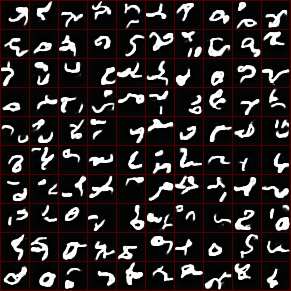

e2a3cf325e945c1a0be38073933f5938


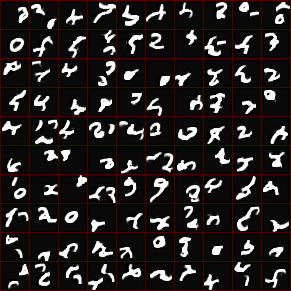

4a4b3a3a4562d7102aceb49eab12c8c0


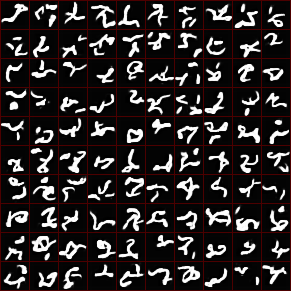

7e7632c0f86786bda97931c4e88bbfd7


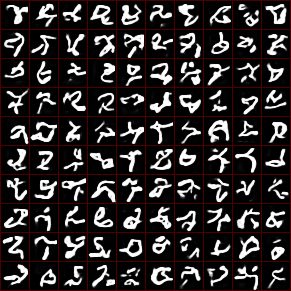

d8fd724967c9d8275c94886f01ac1ae2


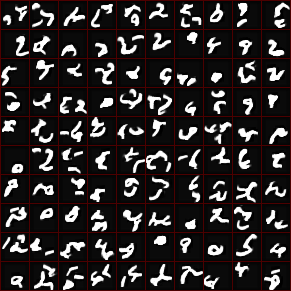

68adffea6c98fedf329644122d56fa36


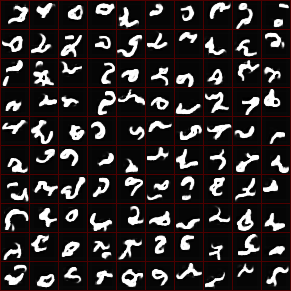

07b20d3a7f536f58e597c818cf9c83dc


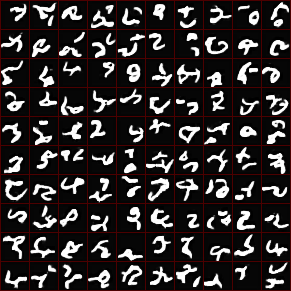

f316dedd30ebc5f51c4678f07979436c


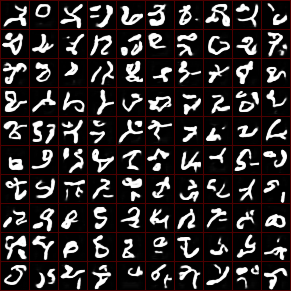

901dad8ec11f23191d86fa6279d47c65


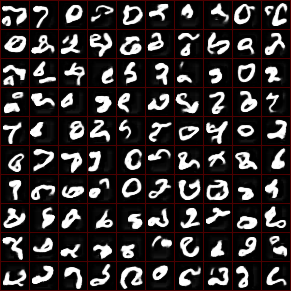

dae42be52c3dca03c9bcba0b8feafb5b


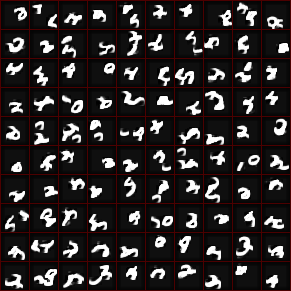

In [3]:
d = df_full.copy()
#d['y'] = d['emnist_letters_count']
d['y'] =  d['emnist_letters_count'] + 5*d['emnist_object'] + 10*d['letters_diversity']
#d['y'] =  30*d['emnist_digits_count'] + d['emnist_objectness']
#d['y'] = d['letters_objectness']
d = d.sort_values(by='y', ascending=False)
show(d.iloc[0:10])

In [ ]:
labels = [
    'digits_count', 
    'letters_count', 
    'digits_objectness', 
    'letters_objectness', 
    'digits_and_letters_objectness', 
    'emnist_objectness',
    'digits_object',
    'letters_object'
]

d = df_full[labels].corr()
def m(val):
    color = 'yellow' if abs(val) > 0.8 else 'white'
    return 'background-color: %s' % color

d = d.style.applymap(m)
d

6bb78c372599de340e0d5cf8bc66c536


/home/ubuntu/miniconda2/envs/python3/lib/python3.5/site-packages/skimage/util/dtype.py:110: UserWarning: Possible precision loss when converting from float64 to uint8
  "%s to %s" % (dtypeobj_in, dtypeobj))


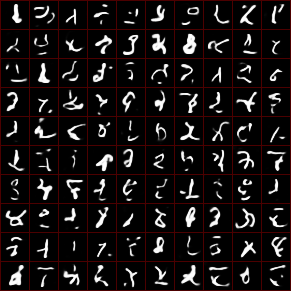

dda6b69cd93d18e48161b8c02976a550


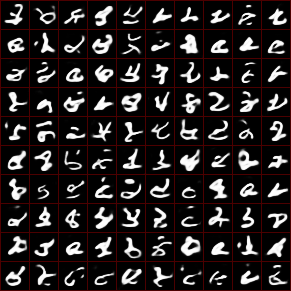

397df4acae0d1690daefd61015d898da


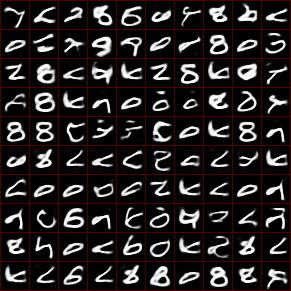

a802d0dcba5c131d31b2f59bbda9ac52


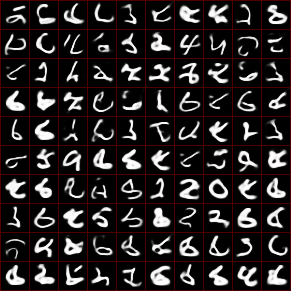

f7a80edd7d1c9c90515651e3e86798d4


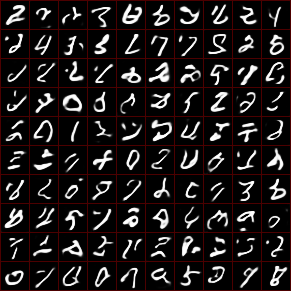

0bd0130fbdc3c67d7a069052005c15e9


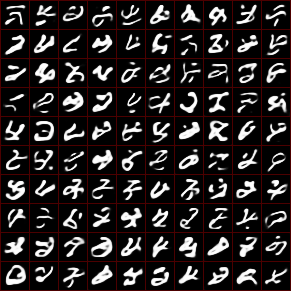

bb8051dece1c1d1c64b96ec2a6e53179


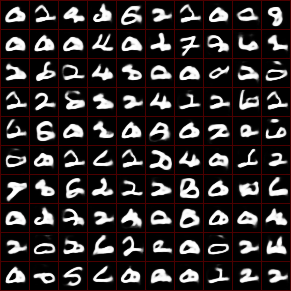

441a5e48880e2ba120ee08919b15d5f3


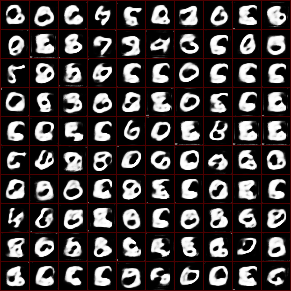

93796d92288367753127039b1bc8bb9f


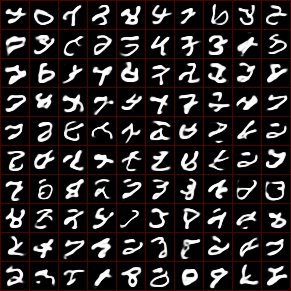

e3da035117e12037def6595989c7228e


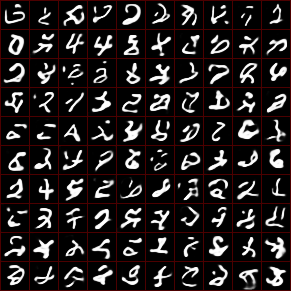

In [26]:
d  = df_full[df_full['nb_layers']==6]
d = d.sort_values(by='letters_count', ascending=False)
show(d.iloc[0:10])

In [27]:
d[['nb_layers', 'bottleneck', 'stride', 'zero_ratio', 'noise']]

,nb_layers,bottleneck,stride,zero_ratio,noise
job_id,,,,,
6bb78c372599de340e0d5cf8bc66c536,6,128.0,0.0,NaN,NaN
dda6b69cd93d18e48161b8c02976a550,6,64.0,NaN,NaN,NaN
397df4acae0d1690daefd61015d898da,6,16.0,NaN,NaN,NaN
a802d0dcba5c131d31b2f59bbda9ac52,6,32.0,NaN,NaN,NaN
f7a80edd7d1c9c90515651e3e86798d4,6,128.0,NaN,0.7,NaN
0bd0130fbdc3c67d7a069052005c15e9,6,128.0,NaN,0.2,NaN
bb8051dece1c1d1c64b96ec2a6e53179,6,128.0,NaN,0.9,NaN
441a5e48880e2ba120ee08919b15d5f3,6,128.0,1.0,NaN,NaN
93796d92288367753127039b1bc8bb9f,6,128.0,NaN,0.7,NaN


In [ ]:
ae = load('../results/mnist_dense2')

In [28]:
import numpy as np
j = '93796d92288367753127039b1bc8bb9f'
X = np.load('../results/jobs/{}/gen/generated.npz'.format(j))['generated']

In [29]:
d = X>0.5
d = d.reshape((d.shape[0], -1))
d = [tuple(e.tolist()) for e in d]
ratio = len(set(d)) / len(d)
print(ratio)

0.99
